<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>



# Laboratorio de Codificación de Variables Categóricas

AutoRenew, la empresa líder en la venta de coches de segunda mano, continúa con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Hasta ahora, has realizado un análisis exploratorio, gestionado los valores nulos y tratado los outliers en el conjunto de datos. El siguiente paso en el proceso de preprocesamiento es manejar las variables categóricas para que el modelo de machine learning pueda interpretarlas correctamente.

En este laboratorio, te centrarás en la **codificación de variables categóricas**. Dado que los modelos de machine learning requieren datos numéricos para funcionar, es crucial convertir las variables categóricas en un formato que los algoritmos puedan procesar. Trabajarás con el mismo conjunto de datos que has utilizado en los laboratorios anteriores, enfocándote ahora en transformar las columnas categóricas de manera efectiva.

**Instrucciones:**



In [3]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import numpy as np
# Para la visualización 
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Otros objetivos
# -----------------------------------------------------------------------
import math
from itertools import combinations
# Para pruebas estadísticas
# -----------------------------------------------------------------------
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder, CountEncoder
import sys
sys.path.append("../../")
import src.soporte_encoding  as se
from src.soporte_graficas import (
    visualizar_categoricas
)

In [4]:
df = pd.read_csv("../../datos/03_Modelo3/05_autorenew_outliers_gestionados.csv",index_col=0)

1. **Identificación de Variables Categóricas:** Revisa el conjunto de datos e identifica las columnas que contienen variables categóricas. Estas son las columnas que contienen texto o categorías que necesitan ser transformadas en valores numéricos para ser utilizadas en el modelo de machine learning.


**Nota:** Este laboratorio es parte de una serie continua en la que utilizas el mismo conjunto de datos a lo largo de la semana. Documenta bien los pasos que sigas, ya que esta codificación será clave para los modelos que desarrollarás más adelante.



# **Identificación de Variables Categóricas:**

Primero vamos a ver nuestro conjunto de datos

In [5]:
df.sample()

,seller,offerType,brand,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,powerCV,price,yearOfRegistration,price_robust_scaler,powerCV_robust_scaler,tipo_outliers
93876,private,offer,citroen,other,diesel,manually,no,100000.0,108.0,7333.0,The 2000,0.674677,-0.045249,No es Outlier


In [6]:
df.columns

Index(['seller', 'offerType', 'brand', 'vehicleType', 'fuelType', 'gearbox',
       'notRepairedDamage', 'kilometer', 'powerCV', 'price',
       'yearOfRegistration', 'price_robust_scaler', 'powerCV_robust_scaler',
       'tipo_outliers'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277391 entries, 0 to 277390
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   seller                 277391 non-null  object 
 1   offerType              277391 non-null  object 
 2   brand                  277391 non-null  object 
 3   vehicleType            277391 non-null  object 
 4   fuelType               277391 non-null  object 
 5   gearbox                277391 non-null  object 
 6   notRepairedDamage      277391 non-null  object 
 7   kilometer              277391 non-null  float64
 8   powerCV                277391 non-null  float64
 9   price                  277391 non-null  float64
 10  yearOfRegistration     277391 non-null  object 
 11  price_robust_scaler    277391 non-null  float64
 12  powerCV_robust_scaler  277391 non-null  float64
 13  tipo_outliers          277391 non-null  object 
dtypes: float64(5), object(9)
memory usage: 31

In [8]:
for col in df.columns: #Para imprimirme las columnas
    #print(f"- {col}")
    pass

### Que columnas tenemos y que tipo son?
- seller: Object
- offerType: Object
- brand: Object: NUEVO DEL MODELO 3, la eliminamos
- vehicleType: Object
- fuelType: Object
- gearbox: Object
- notRepairedDamage: Object
- kilometer: Float
- powerCV: Object
- price: Float
- yearOfRegistration: Float -> es categórica 
- price_robust_scaler: Object
- powerCV_robust_scaler: Object
- tipo_outliers: Object -> Esta la eliminamos, ya no nos vale 

In [9]:
df.drop(columns=["tipo_outliers","brand"],inplace=True)

Para convertirla a object primero la paso a int y después a object, asi me quito el decimal de la misma

In [10]:
df["kilometer"] = df["kilometer"].astype(int).astype("O")
df.sample()

,seller,offerType,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,powerCV,price,yearOfRegistration,price_robust_scaler,powerCV_robust_scaler
45353,private,offer,other,petrol,automatic,no,150000,145.0,1690.0,The 2000,-0.235484,0.512827


### Que columnas son categóricas
Muchas, pero más específicamente:
- seller: Quien lo vende
- offerType: Tipo de venta
- brand: marca del vehículo
- vehicleType: tipo de coche
- fuelType: Tipo de combustible del mismo
- gearbox: Tipo de caja de cambios.
- notRepairedDamage: Si el coche tiene daños no reparados
- kilometer: Rango de kilometros del mismo 
- yearOfRegistration: Década del vehículo

2. **Selección de Técnicas de Codificación:** Decide qué técnica(s) de codificación aplicar a cada variable categórica. Algunas de las opciones que tienes son:

   - **Label Encoding:** Asigna un número único a cada categoría dentro de una variable.

   - **One-Hot Encoding:** Crea nuevas columnas binarias (0/1) para cada categoría única en una variable.

   - **Target Encoding:** Utiliza la media del target (en este caso, el `price`) para codificar las categorías, si consideras que podría ser útil.



# Conocer si hay orden o no
Para poder saber si tenemos orden o no vamos a plotear las columnas categóricas

In [11]:
cols_categoricas = df.select_dtypes("O").columns


Vamos a pintar un boxplot primero

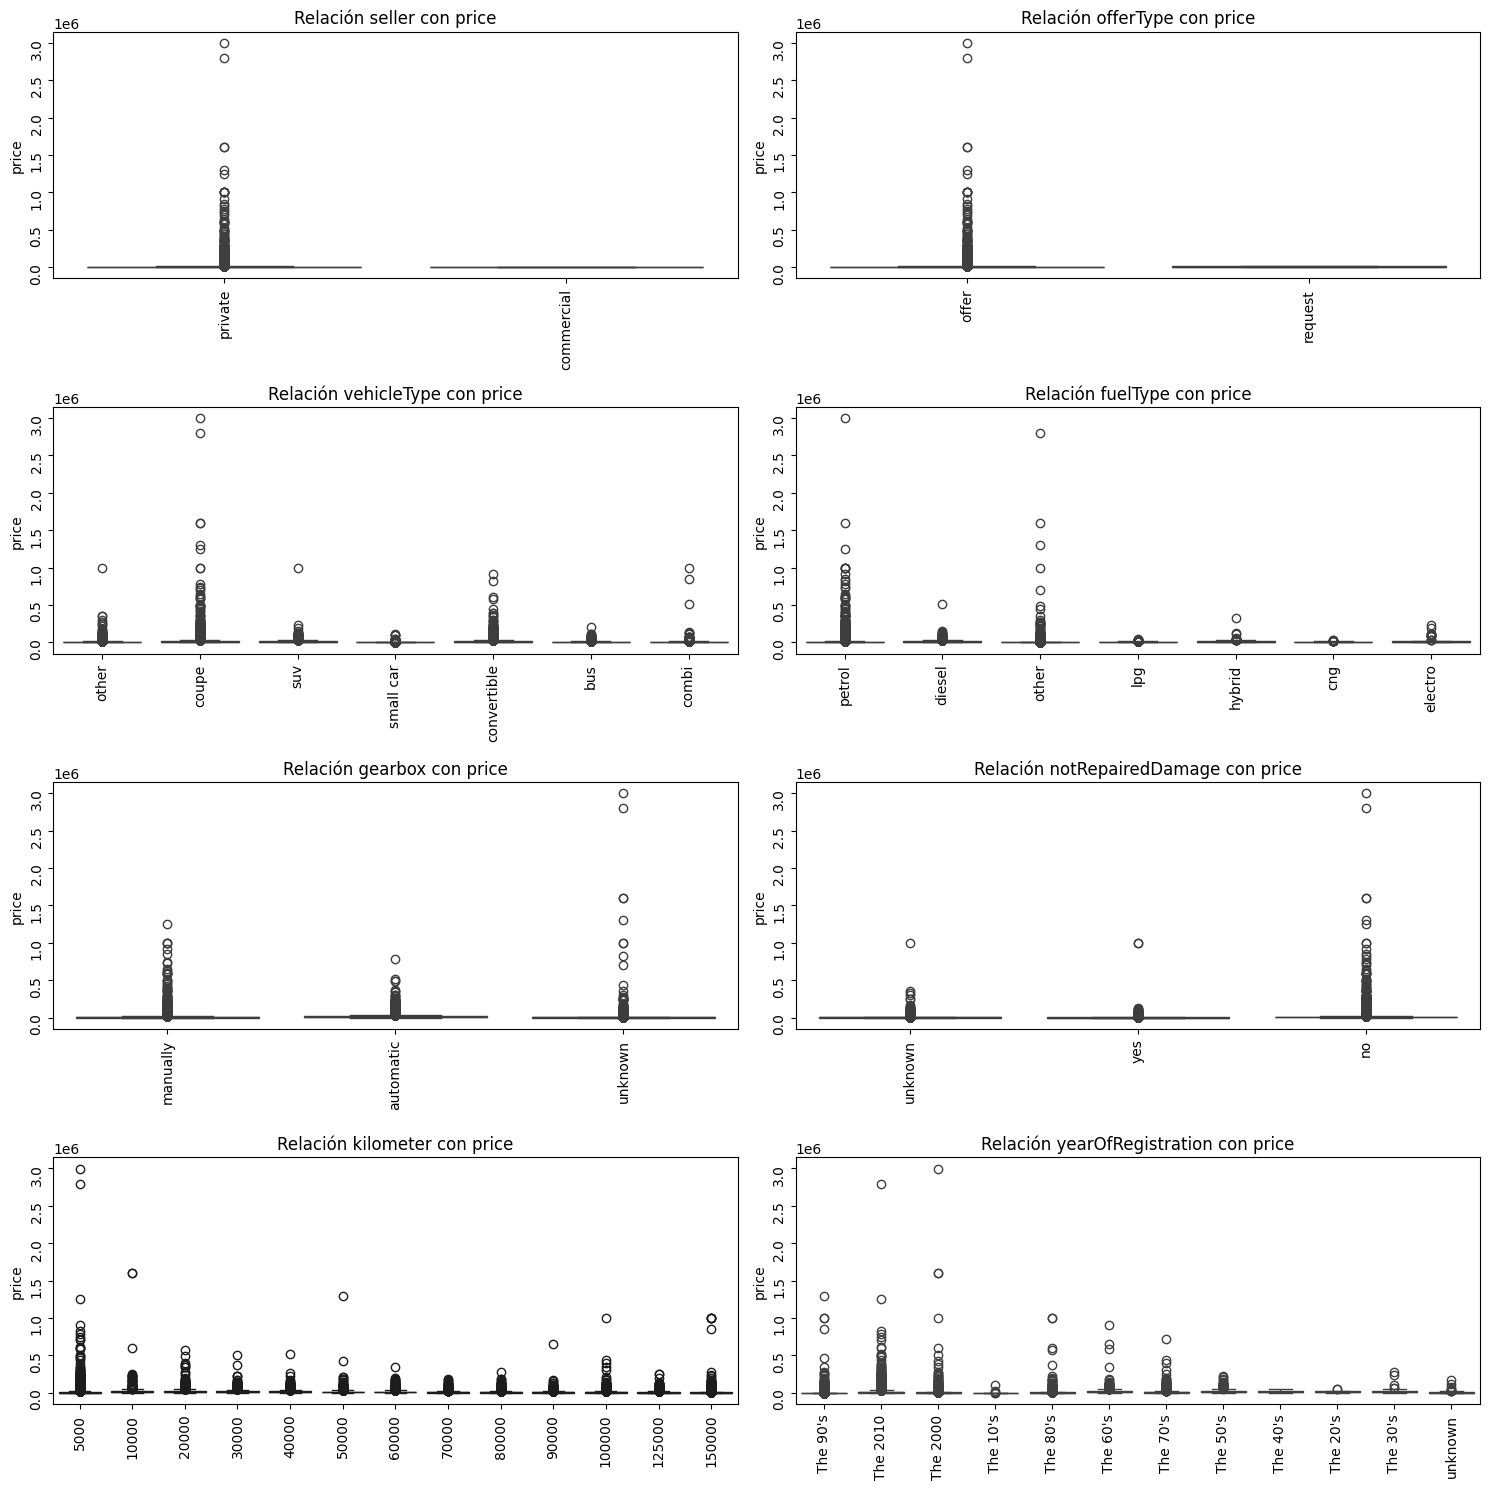

In [12]:
visualizar_categoricas(df,cols_categoricas,"price","boxplot",grafica_size=(15,15))

Bueno yo no se vosotros, pero yo me he quedado igual, probamos con el barplot?

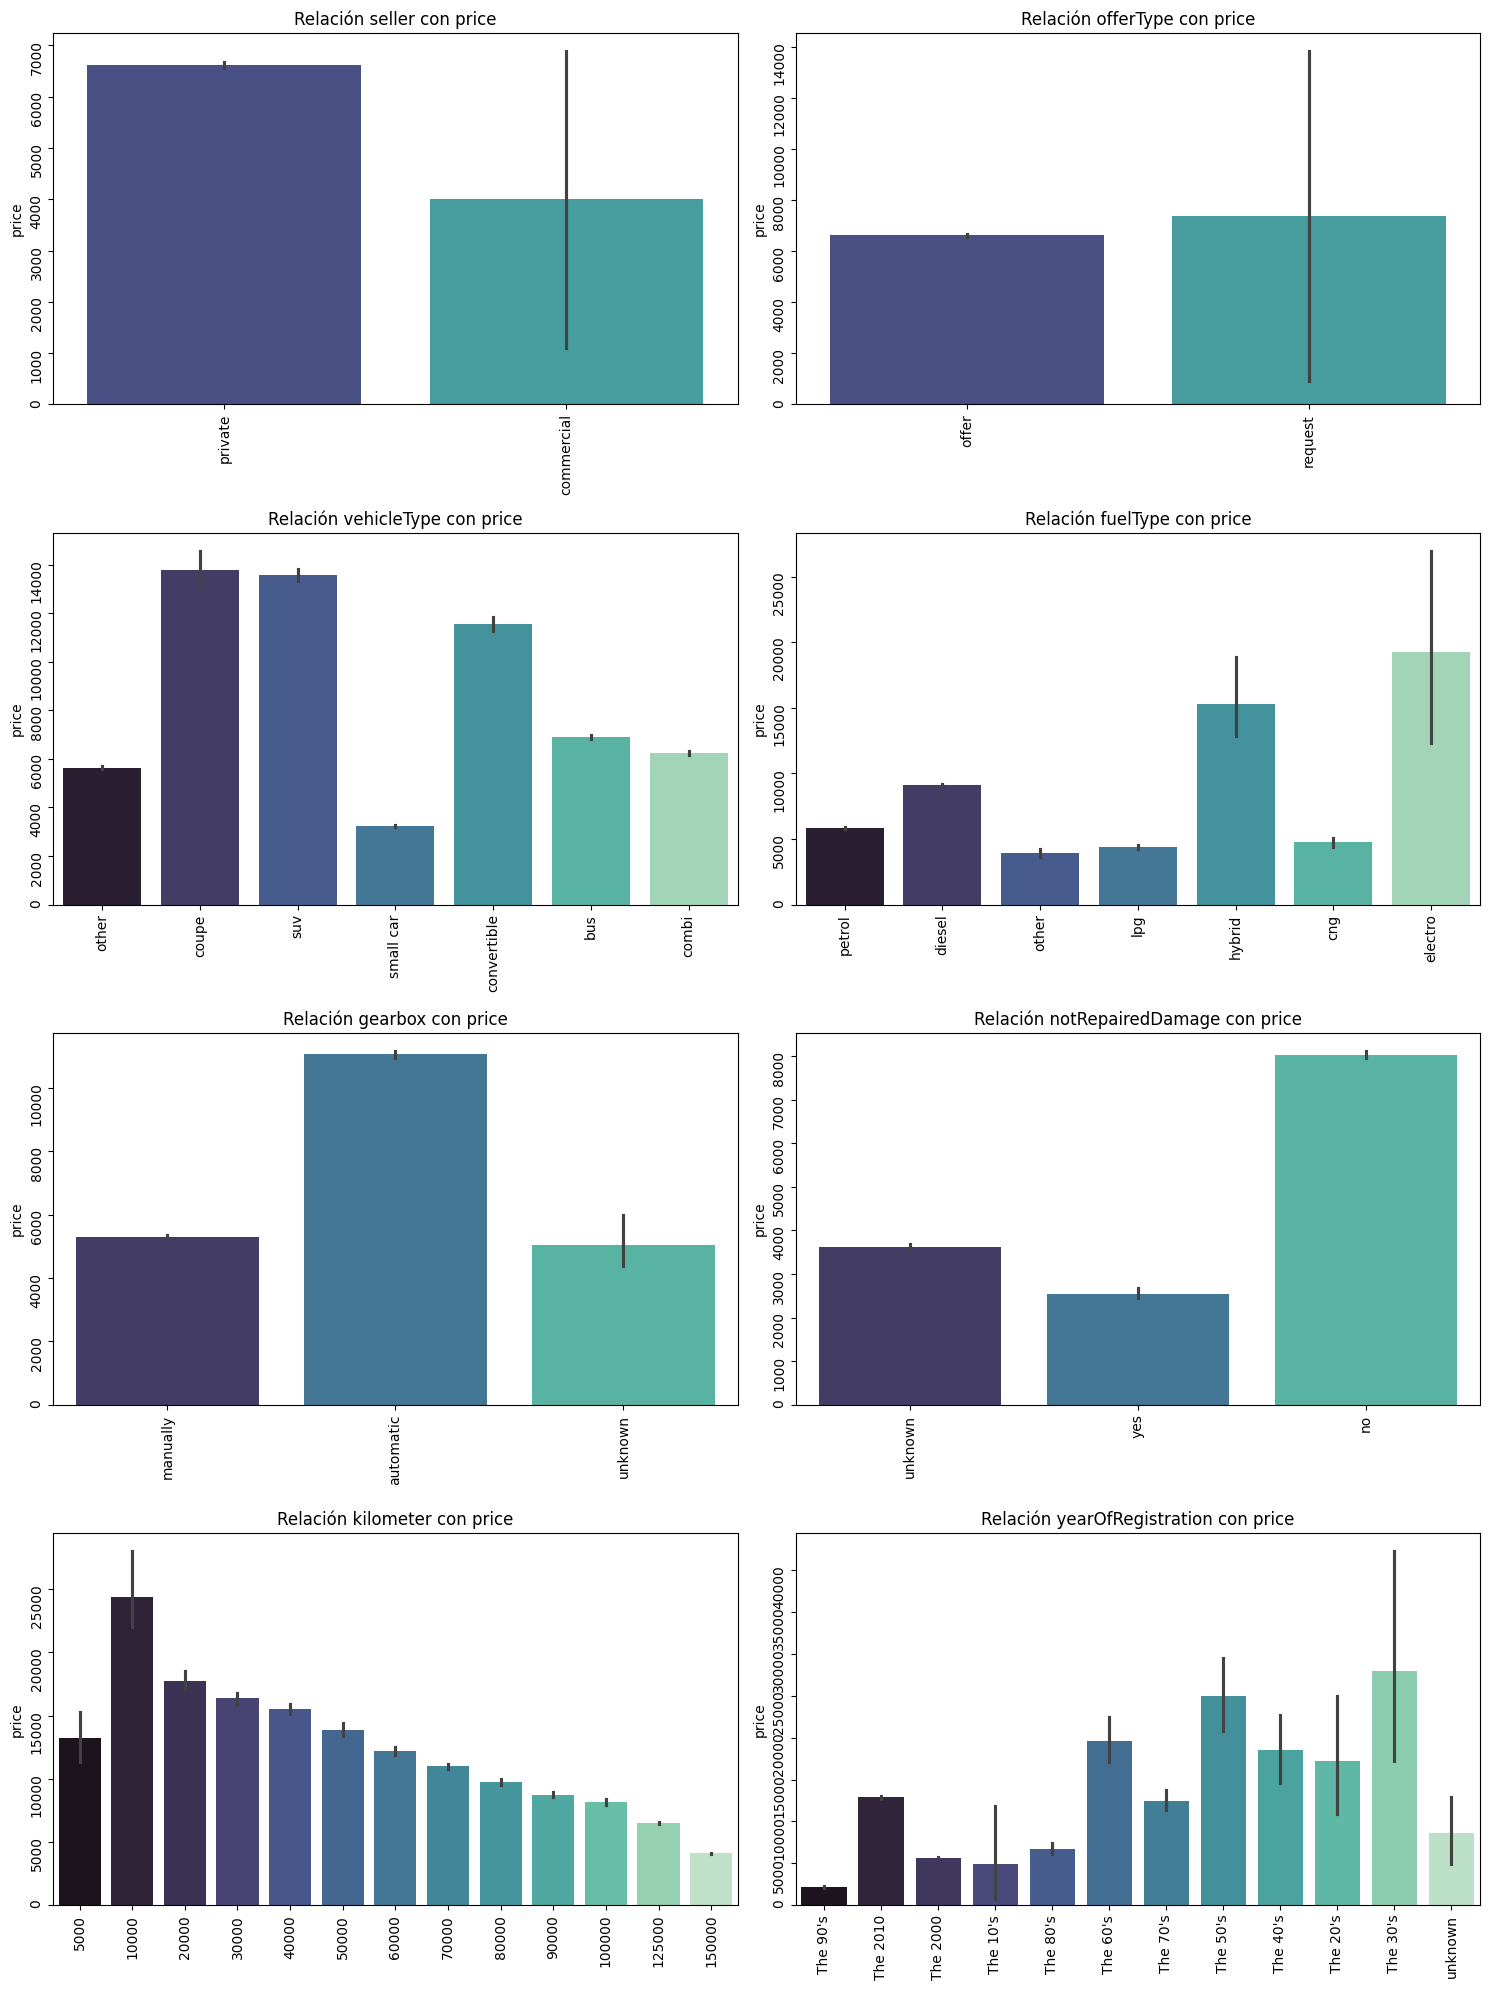

In [13]:
visualizar_categoricas(df,cols_categoricas,"price","barplot",grafica_size=(15,20))

# Sobre las Gráficas
- Parece que, efectivamente hay orden en casi todas las relaciones, ahora, viendolo sólo no nos vale, somos buenos pero no somos adivinos
- Como apreciacion personal eso de que coches de 5000 km estén tan baratos me chirría, pero ya hemos limpiado así que...

# Analicemos estadísticamente

### Convertir kilometer a category
- Al final arreglo la función para que pase a str el valor que saca de la tabla

In [14]:
df["kilometer"] = df["kilometer"].astype("category")

In [15]:
# instanciamos la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
asunciones = se.Asunciones(dataframe = df, columna_numerica = "price")
print("\n-------------\n")


for categoria in cols_categoricas:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = se.TestEstadisticos(df, "price", categoria)
    test.run_all_tests()
    print("\n###########################\n")


-------------

Estamos analizando la variable SELLER
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable seller las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['private', 'commercial']

Realizando test de Mannwhitneyu...
Estadístico del Test de Mann-Whitney U: 306770.0
Valor p: 0.7952904288484476
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,2621.2637,0.8092,-18658.754,23901.2813,commercial-private



###########################

Estamos analizando la variable OFFERTYPE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable offerType las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['offer', 'request']

Realizando test de Mannwhitneyu...
Estadístico del Test de Mann-Whitney U: 946298.5
Valor p: 0.5606044601992327
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,754.4382,0.9042,-11531.6752,13040.5517,offer-request



###########################

Estamos analizando la variable VEHICLETYPE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable vehicleType las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['other', 'coupe', 'suv', 'small car', 'convertible', 'bus', 'combi']

Realizando test de Kruskal...
Estadístico de prueba: 31496.892117487296
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-690.0989,0.0000,-1037.0266,-343.1711,bus-combi
1,4632.3905,0.0000,4203.1260,5061.6550,bus-convertible
2,6848.8398,0.0000,6396.7786,7300.9010,bus-coupe
3,-1276.2065,0.0000,-1593.1705,-959.2425,bus-other
4,-3675.5115,0.0000,-4017.6794,-3333.3436,bus-small car
5,6633.3879,0.0000,6147.1097,7119.6662,bus-suv
6,5322.4893,0.0000,4944.7793,5700.1994,combi-convertible
7,7538.9387,0.0000,7135.5082,7942.3692,combi-coupe
8,-586.1076,0.0000,-828.7246,-343.4906,combi-other
9,-2985.4127,0.0000,-3260.1411,-2710.6842,combi-small car



###########################

Estamos analizando la variable FUELTYPE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable fuelType las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['petrol', 'diesel', 'other', 'lpg', 'hybrid', 'cng', 'electro']

Realizando test de Kruskal...
Estadístico de prueba: 30283.972149209854
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,4387.2005,0.0000,2365.7163,6408.6846,cng-diesel
1,14532.2883,0.0000,9562.2765,19502.3000,cng-electro
2,10528.9304,0.0000,7042.9245,14014.9363,cng-hybrid
3,-342.3676,0.9991,-2460.6951,1775.9598,cng-lpg
4,-805.3455,0.9066,-2840.1456,1229.4546,cng-other
5,1112.3668,0.6662,-906.0141,3130.7476,cng-petrol
6,10145.0878,0.0000,5599.2917,14690.8839,diesel-electro
7,6141.7299,0.0000,3292.9614,8990.4985,diesel-hybrid
8,-4729.5681,0.0000,-5400.8030,-4058.3332,diesel-lpg
9,-5192.5460,0.0000,-5514.5032,-4870.5887,diesel-other



###########################

Estamos analizando la variable GEARBOX
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable gearbox las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['manually', 'automatic', 'unknown']

Realizando test de Kruskal...
Estadístico de prueba: 23875.059253171177
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-5751.8230,0.000,-5913.3039,-5590.3421,automatic-manually
1,-6000.8913,0.000,-6337.3026,-5664.4801,automatic-unknown
2,-249.0683,0.154,-564.8589,66.7223,manually-unknown



###########################

Estamos analizando la variable NOTREPAIREDDAMAGE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable notRepairedDamage las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['unknown', 'yes', 'no']

Realizando test de Kruskal...
Estadístico de prueba: 40248.779704239954
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-4404.7232,0.0,-4578.1026,-4231.3437,no-unknown
1,-5494.3473,0.0,-5721.3921,-5267.3025,no-yes
2,-1089.6241,0.0,-1351.5930,-827.6553,unknown-yes



###########################

Estamos analizando la variable KILOMETER
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable kilometer las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: [150000, 125000, 90000, 30000, 70000, 5000, 100000, 60000, 20000, 80000, 50000, 40000, 10000]

Realizando test de Kruskal...
Estadístico de prueba: 51759.48819531286
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,11169.8918,0.0000,9793.3066,12546.4769,5000-10000
1,4533.1048,0.0000,3552.7095,5513.5001,5000-20000
2,3153.0051,0.0000,2184.7121,4121.2980,5000-30000
3,2306.1931,0.0000,1352.6733,3259.7129,5000-40000
4,603.4389,0.6031,-311.9225,1518.8002,5000-50000
...,...,...,...,...,...
73,-2235.4871,0.0000,-2781.4588,-1689.5155,90000-125000
74,-4634.4057,0.0000,-5119.9679,-4148.8436,90000-150000
75,-1638.3813,0.0000,-2143.9813,-1132.7812,100000-125000
76,-4037.2999,0.0000,-4476.9781,-3597.6216,100000-150000



###########################

Estamos analizando la variable YEAROFREGISTRATION
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable yearOfRegistration las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ["The 90's", 'The 2010', 'The 2000', "The 10's", "The 80's", "The 60's", "The 70's", "The 50's", "The 40's", "The 20's", "The 30's", 'unknown']

Realizando test de Kruskal...
Estadístico de prueba: 76790.93821418681
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,12355.4485,0.2417,-2771.9544,27482.8514,The 10's-The 20's
1,751.4231,1.0000,-7706.0103,9208.8565,The 10's-The 2000
2,7988.1810,0.0855,-470.5594,16446.9214,The 10's-The 2010
3,23114.4625,0.0000,12488.3793,33740.5457,The 10's-The 30's
4,13670.5455,0.0102,1711.2834,25629.8075,The 10's-The 40's
...,...,...,...,...,...
61,-10240.4900,0.0000,-11317.1596,-9163.8203,The 70's-The 90's
62,-3817.0603,0.2651,-8568.2865,934.1659,The 70's-unknown
63,-4471.4390,0.0000,-5155.6333,-3787.2447,The 80's-The 90's
64,1951.9907,0.9702,-2725.9420,6629.9234,The 80's-unknown



###########################



# Todas las columnas tienen orden salvo una
Veamos

In [16]:
df["seller"].value_counts()

seller
private       277389
commercial         2
Name: count, dtype: int64

Considerando lo que nos indica la columna y la cantidad tan desigual que tiene cada una, he decidido eliminar la columna ya que no nos aporta valor

In [17]:
df.drop(columns="seller",inplace=True)

# ¿Que codificación usar?

Viendo los datos que tenemos podemos pensar en dos:
- **Target Encoding**: Reemplaza cada categoría con la media del objetivo para esa categoría.

- **Frequency Encoding**: Codifica las categorías según su frecuencia en los datos. Reemplaza cada categoría con la frecuencia de esa categoría en los datos.

Pero si somos realistas, frequency asignara pesos incorrectos, pues no es necesariamente real que porque bmw o audi (brand) aparezca más, el precio sea más alto, así que nos quedamos con target encoding

In [18]:
df_target = df.copy()

3. **Aplicación de la Codificación:** Implementa las técnicas seleccionadas en las variables categóricas. Asegúrate de revisar cómo estas transformaciones afectan el conjunto de datos y de mantener un registro de los cambios realizados.



In [19]:
df.columns

Index(['offerType', 'vehicleType', 'fuelType', 'gearbox', 'notRepairedDamage',
       'kilometer', 'powerCV', 'price', 'yearOfRegistration',
       'price_robust_scaler', 'powerCV_robust_scaler'],
      dtype='object')

# Target Encoding

In [20]:
df_target

,offerType,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,powerCV,price,yearOfRegistration,price_robust_scaler,powerCV_robust_scaler
0,offer,other,petrol,manually,unknown,150000,124.000000,480.0,The 90's,-0.430645,0.196081
1,offer,coupe,diesel,manually,yes,125000,187.000000,18300.0,The 2010,2.443548,1.146318
2,offer,suv,diesel,automatic,unknown,125000,161.000000,9800.0,The 2000,1.072581,0.754157
3,offer,small car,petrol,manually,no,150000,74.000000,1500.0,The 2000,-0.266129,-0.558076
4,offer,small car,diesel,manually,no,90000,68.000000,3600.0,The 2000,0.072581,-0.648575
...,...,...,...,...,...,...,...,...,...,...,...
277386,offer,other,other,unknown,unknown,20000,108.197668,2200.0,The 2000,-0.153226,-0.042268
277387,offer,convertible,petrol,automatic,no,125000,100.000000,1199.0,The 2000,-0.314677,-0.165915
277388,offer,bus,diesel,manually,no,150000,101.000000,9200.0,The 90's,0.975806,-0.150831
277389,offer,combi,diesel,manually,unknown,150000,99.000000,3400.0,The 2000,0.040323,-0.180998


# Nos quitamos "price_robust_scaler" y power CV, "
Queremos predecir el precio de verdad y usar los CV adaptados

In [21]:
df_target.drop(columns=["price_robust_scaler","powerCV"],inplace=True)

In [22]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277391 entries, 0 to 277390
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   offerType              277391 non-null  object  
 1   vehicleType            277391 non-null  object  
 2   fuelType               277391 non-null  object  
 3   gearbox                277391 non-null  object  
 4   notRepairedDamage      277391 non-null  object  
 5   kilometer              277391 non-null  category
 6   price                  277391 non-null  float64 
 7   yearOfRegistration     277391 non-null  object  
 8   powerCV_robust_scaler  277391 non-null  float64 
dtypes: category(1), float64(2), object(6)
memory usage: 19.3+ MB


In [23]:
target_encoder = TargetEncoder(cols=["offerType","vehicleType","fuelType","gearbox","notRepairedDamage","kilometer","yearOfRegistration","powerCV_robust_scaler"])
target_encoding = target_encoder.fit_transform(df_target,df_target[["price"]])

In [24]:
target_encoding

,offerType,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,price,yearOfRegistration,powerCV_robust_scaler
0,6621.228444,5641.658391,5850.272404,5308.594693,3628.732734,4091.637035,480.0,2173.388480,11660.701050
1,6621.228444,13766.704709,9125.106077,5308.594693,2539.108625,6490.555619,18300.0,12862.999172,15878.805939
2,6621.228444,13551.252805,9125.106077,11060.417702,3628.732734,6490.555619,9800.0,5626.241302,8272.414349
3,6621.228444,3242.353344,5850.272404,5308.594693,8033.455905,4091.637035,1500.0,5626.241302,2410.382681
4,6621.228444,3242.353344,9125.106077,5308.594693,8033.455905,8726.042754,3600.0,5626.241302,5328.114969
...,...,...,...,...,...,...,...,...,...
277386,6621.228444,5641.658391,3932.560120,5059.526374,3628.732734,17750.853765,2200.0,5626.241302,2200.000000
277387,6621.228444,11550.255341,5850.272404,11060.417702,8033.455905,6490.555619,1199.0,5626.241302,2746.872077
277388,6621.228444,6917.864875,9125.106077,5308.594693,8033.455905,4091.637035,9200.0,2173.388480,4821.822973
277389,6621.228444,6227.766016,9125.106077,5308.594693,3628.732734,4091.637035,3400.0,5626.241302,2318.112609


In [25]:
target_encoding.reset_index(drop=True,inplace=True)

In [27]:
target_encoding.to_csv("../../datos/03_Modelo3/06_autorenew_target_encoded.csv")

# Frequency Encoder
Probemos el Frequency Encoder

In [28]:
df_frequency = df.copy()

In [29]:
frequency_encoder = CountEncoder(cols=["offerType","vehicleType","fuelType","gearbox","notRepairedDamage","kilometer","yearOfRegistration","powerCV_robust_scaler"])
frequency_encoding = frequency_encoder.fit_transform(df_target,df_target[["price"]])

In [30]:
frequency_encoding.to_csv("../../datos/03_Modelo3/06_autorenew_frequency_encoded.csv")

4. **Verificación del Conjunto de Datos Transformado:** Una vez que hayas aplicado la codificación, verifica que el conjunto de datos resultante esté listo para ser utilizado en el modelo de machine learning. Asegúrate de que no queden variables categóricas sin codificar y que la estructura del conjunto de datos sea adecuada para el análisis.


In [31]:
target_encoding = pd.read_csv("../../datos/03_Modelo3/06_autorenew_target_encoded.csv",index_col=0)

In [32]:
target_encoding

,offerType,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,price,yearOfRegistration,powerCV_robust_scaler
0,6621.228444,5641.658391,5850.272404,5308.594693,3628.732734,4091.637035,480.0,2173.388480,11660.701050
1,6621.228444,13766.704709,9125.106077,5308.594693,2539.108625,6490.555619,18300.0,12862.999172,15878.805939
2,6621.228444,13551.252805,9125.106077,11060.417702,3628.732734,6490.555619,9800.0,5626.241302,8272.414349
3,6621.228444,3242.353344,5850.272404,5308.594693,8033.455905,4091.637035,1500.0,5626.241302,2410.382681
4,6621.228444,3242.353344,9125.106077,5308.594693,8033.455905,8726.042754,3600.0,5626.241302,5328.114969
...,...,...,...,...,...,...,...,...,...
277386,6621.228444,5641.658391,3932.560120,5059.526374,3628.732734,17750.853765,2200.0,5626.241302,2200.000000
277387,6621.228444,11550.255341,5850.272404,11060.417702,8033.455905,6490.555619,1199.0,5626.241302,2746.872077
277388,6621.228444,6917.864875,9125.106077,5308.594693,8033.455905,4091.637035,9200.0,2173.388480,4821.822973
277389,6621.228444,6227.766016,9125.106077,5308.594693,3628.732734,4091.637035,3400.0,5626.241302,2318.112609


In [33]:
frequency_encoding

,offerType,vehicleType,fuelType,gearbox,notRepairedDamage,kilometer,price,yearOfRegistration,powerCV_robust_scaler
0,277385,100975,164649,199984,53819,166074,480.0,61043,15240
1,277385,15947,81488,199984,28152,31437,18300.0,61594,1448
2,277385,12654,81488,63890,53819,31437,9800.0,145631,4711
3,277385,54505,164649,199984,195420,166074,1500.0,145631,14631
4,277385,54505,81488,199984,195420,10923,3600.0,145631,3053
...,...,...,...,...,...,...,...,...,...
277386,277385,100975,25657,13517,53819,5033,2200.0,145631,264
277387,277385,19049,164649,63890,195420,31437,1199.0,145631,8466
277388,277385,24296,81488,199984,195420,166074,9200.0,61043,4649
277389,277385,49965,81488,199984,53819,166074,3400.0,145631,1261


Todos los datos están categorizados